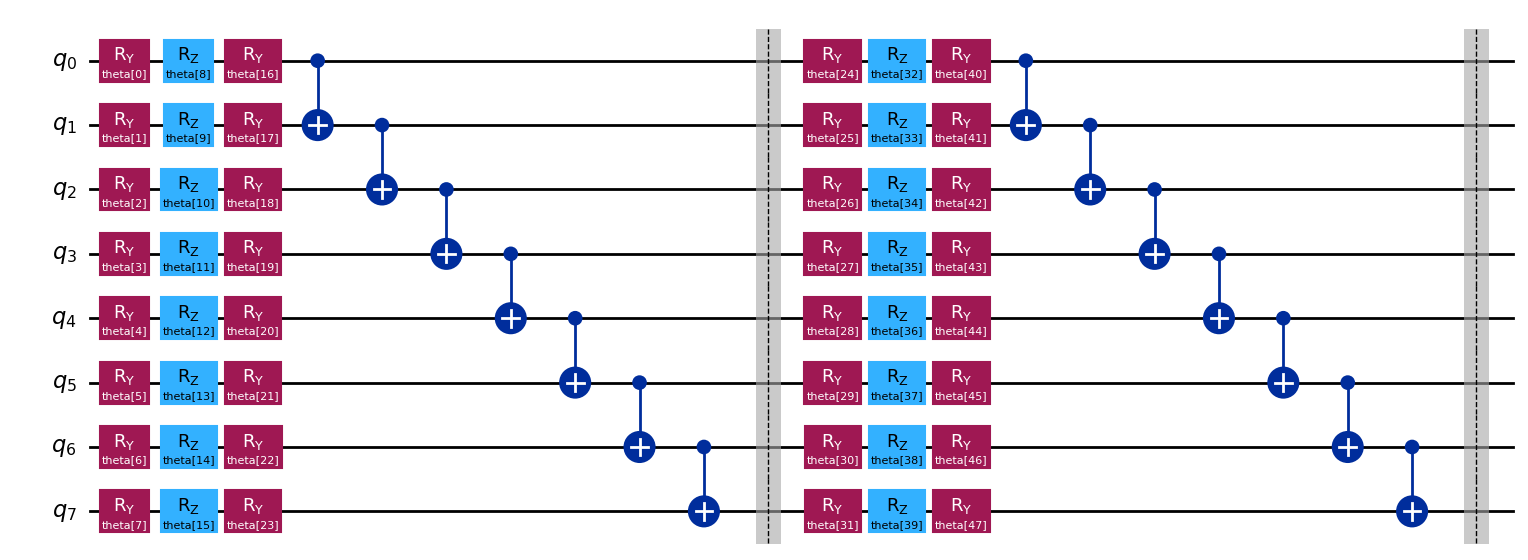

In [6]:
import qiskit

n_qubits=8
n=3
theta = qiskit.circuit.ParameterVector('theta',2*n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(theta[i], i)
for i in range(n_qubits):
    qc.rz(theta[i+n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+2*n_qubits], i)

for i in range(n_qubits-1):
    qc.cx(i, i+1)
qc.barrier()

for i in range(n_qubits):
    qc.ry(theta[i+3*n_qubits], i)
for i in range(n_qubits):
    qc.rz(theta[i+4*n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+5*n_qubits], i)

for i in range(n_qubits-1):
    qc.cx(i, i+1)
qc.barrier()

qc.draw('mpl')

In [33]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, ADAM, GradientDescent, AQGD
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
mapper=JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)
gradientor = ParamShiftEstimatorGradient(estimator)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, gradient = gradientor)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_26233/568627938.py:11: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


-1.8816967632790051


In [34]:
import numpy as np
optimizers = [ADAM(maxiter=100, lr = 0.1, beta_1 = 0.8, beta_2 = 0.999, eps = 10**(-8)), 
              GradientDescent(maxiter=100, learning_rate = 0.1),
              ]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, gradient = gradientor, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

Optimizer: ADAM        -1.8820882958622498
Optimizer: GradientDescent        -1.1654710874451597


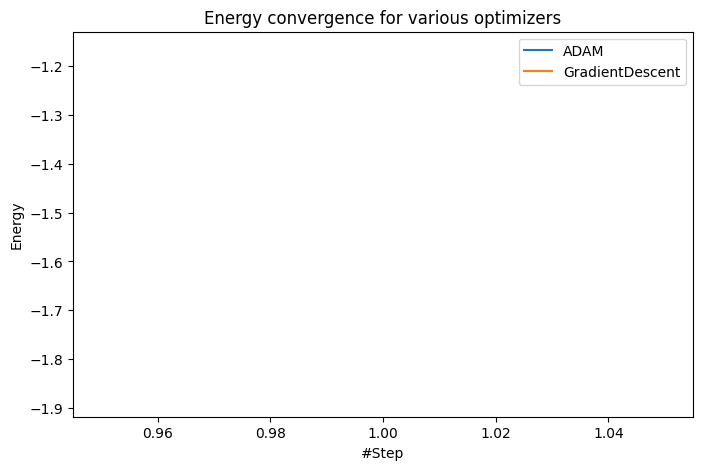

In [35]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('#Step')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right')

-1.8820888154393793


In [7]:
driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
optimizer = SLSQP(maxiter=1000)
estimator = Estimator()
mapper=JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
computation_value = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real

/var/folders/bw/2cm4rnhn0djgg95n4py1pysc0000gp/T/ipykernel_26233/2802137497.py:10: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
